In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import scipy.io

In [2]:
# Settings
input_path = os.path.join('2015_BOE_Chiu')
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

subject_path

['2015_BOE_Chiu/Subject_01.mat',
 '2015_BOE_Chiu/Subject_02.mat',
 '2015_BOE_Chiu/Subject_03.mat',
 '2015_BOE_Chiu/Subject_04.mat',
 '2015_BOE_Chiu/Subject_05.mat',
 '2015_BOE_Chiu/Subject_06.mat',
 '2015_BOE_Chiu/Subject_07.mat',
 '2015_BOE_Chiu/Subject_08.mat',
 '2015_BOE_Chiu/Subject_09.mat',
 '2015_BOE_Chiu/Subject_10.mat']

### Data Visualization

In [3]:
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

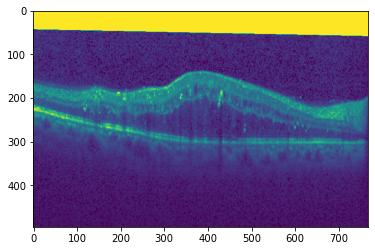

In [4]:
plt.imshow(img_array[25])

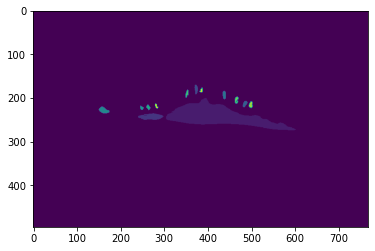

In [5]:
plt.imshow(manual_fluid_array[25])

In [6]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

In [7]:
thresh = np.vectorize(thresh, otypes=[np.float])

In [8]:
subject_path

['2015_BOE_Chiu/Subject_01.mat',
 '2015_BOE_Chiu/Subject_02.mat',
 '2015_BOE_Chiu/Subject_03.mat',
 '2015_BOE_Chiu/Subject_04.mat',
 '2015_BOE_Chiu/Subject_05.mat',
 '2015_BOE_Chiu/Subject_06.mat',
 '2015_BOE_Chiu/Subject_07.mat',
 '2015_BOE_Chiu/Subject_08.mat',
 '2015_BOE_Chiu/Subject_09.mat',
 '2015_BOE_Chiu/Subject_10.mat']

In [10]:
subject_path[:9]

['2015_BOE_Chiu/Subject_01.mat',
 '2015_BOE_Chiu/Subject_02.mat',
 '2015_BOE_Chiu/Subject_03.mat',
 '2015_BOE_Chiu/Subject_04.mat',
 '2015_BOE_Chiu/Subject_05.mat',
 '2015_BOE_Chiu/Subject_06.mat',
 '2015_BOE_Chiu/Subject_07.mat',
 '2015_BOE_Chiu/Subject_08.mat',
 '2015_BOE_Chiu/Subject_09.mat']

In [11]:
def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

100%|██████████| 1/1 [00:07<00:00,  7.57s/it]


In [12]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 284, 284), (99, 1, 196, 196), (11, 1, 284, 284), (11, 1, 196, 196))

### UNet

In [13]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

In [20]:
batch_size = 9
epochs = 15
epoch_lapse = 5
threshold = 0.5
sample_size = None

In [177]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    dice = K.mean((2 * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [15]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        ##print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, bottleneck1.shape)
        ##print('Decode Block 3')
        ##print(bottleneck1.shape, encode_block3.shape)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        ##print(decode_block3.shape)
        ##print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        ##print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        ##print(cat_layer1.shape, encode_block1.shape)
        ##print('Final Layer')
        ##print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        ##print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        ##print(final_layer.shape)
        return  final_layer

In [16]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)
    labels = labels.resize(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [17]:
learning_rate = 0.01
unet = UNet(in_channel=1,out_channel=2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)

In [18]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [174]:
def get_val_metric(x_val, y_val, func): 
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    return func(np.transpose(y_val, (0, 2,3,1))[:, :,:,0], outputs.argmax(1))

In [175]:
get_val_metric(x_val, y_val, iou_coef)

<tf.Tensor: shape=(), dtype=float64, numpy=0.20987947942328916>

In [176]:
get_val_metric(x_val, y_val, dice_coef)

<tf.Tensor: shape=(), dtype=float64, numpy=0.20987947942328916>

In [21]:
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

  0%|          | 0/15 [00:00<?, ?it/s]/Users/surengunturu/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/surengunturu/anaconda3/lib/python3.8/site-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 33%|███▎      | 5/15 [20:02<40:09, 240.95s/it]

Total loss in epoch 5 : 0.6806333661079407 and validation loss : 0.4270118772983551


 67%|██████▋   | 10/15 [39:57<20:06, 241.22s/it]

Total loss in epoch 10 : 0.6830121874809265 and validation loss : 0.5084921717643738


100%|██████████| 15/15 [59:51<00:00, 239.46s/it]

Total loss in epoch 15 : 0.6677640676498413 and validation loss : 0.5495457649230957


## Metric Calculation

In [169]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    dice = K.mean((2 * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [134]:
batch_train_x = torch.from_numpy(x_train[0 * batch_size : (0 + 1) * batch_size]).float()
batch_train_y = torch.from_numpy(y_train[0 * batch_size : (0 + 1) * batch_size]).long()

In [135]:
out1 = unet(batch_train_x).float()

In [153]:
np.transpose(batch_train_y, (0, 2,3,1))[:, :,:,0].shape

torch.Size([9, 196, 196])

In [154]:
np.transpose(out1.detach().numpy(), (0,2,3,1))[:, :,:,0].shape

(9, 196, 196)

#### Two different IOU's, ask which one it is

In [160]:
iou_coef(np.transpose(batch_train_y, (0, 2,3,1))[:, :,:,0], np.transpose(out1.detach().numpy(), (0,2,3,1))[:, :,:,0].astype(int))

<tf.Tensor: shape=(), dtype=float64, numpy=0.0005366603199608783>

In [165]:
iou_coef(np.transpose(batch_train_y, (0, 2,3,1))[:, :,:,0], out1.argmax(1))

<tf.Tensor: shape=(), dtype=float64, numpy=0.2260208656145587>

In [141]:
np.transpose(batch_train_y, (0, 2,3,1))[:, :,:,0]

torch.Size([9, 196, 196])

#### Dice Coeff

In [170]:
dice_coef(np.transpose(batch_train_y, (0, 2,3,1))[:, :,:,0], np.transpose(out1.detach().numpy(), (0,2,3,1))[:, :,:,0].astype(int))

<tf.Tensor: shape=(), dtype=float64, numpy=0.000824687887022421>

In [171]:
dice_coef(np.transpose(batch_train_y, (0, 2,3,1))[:, :,:,0], out1.argmax(1))

<tf.Tensor: shape=(), dtype=float64, numpy=0.2260208656145587>

In [161]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        
        # change below line if using gpu
        # check the one image
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float()).squeeze(0).detach().numpy()
        
        y_true = np.transpose(image_arr, (1,2,0))[:,:,0]
        y_pred = np.transpose(datay[image_indx], (1,2,0))[:,:,0]
        
        
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

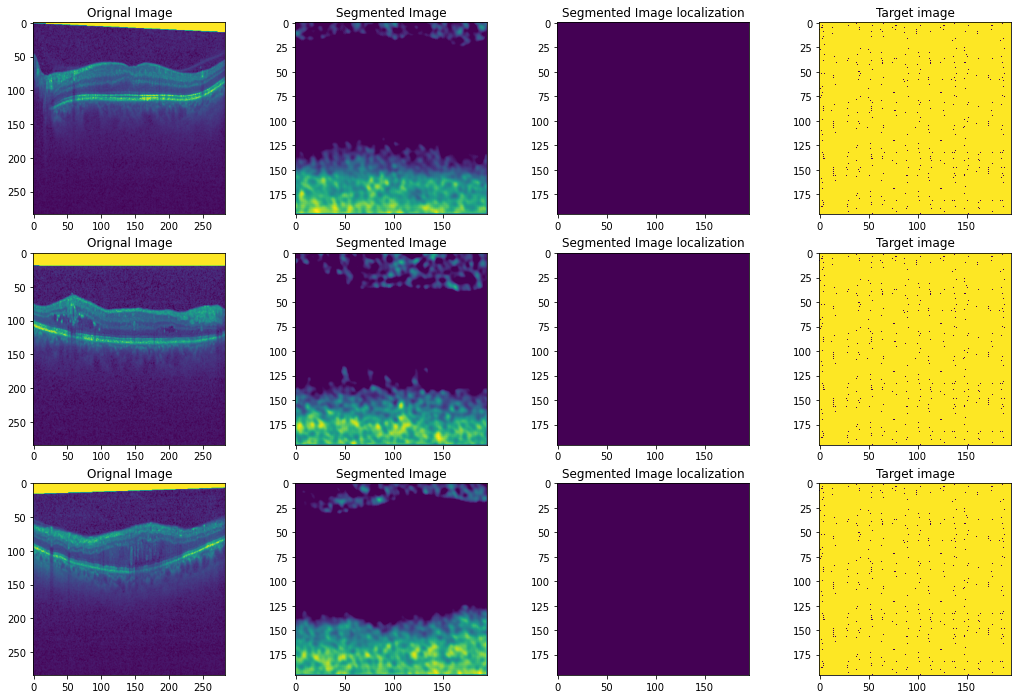

In [162]:
plot_examples(x_train, y_train)

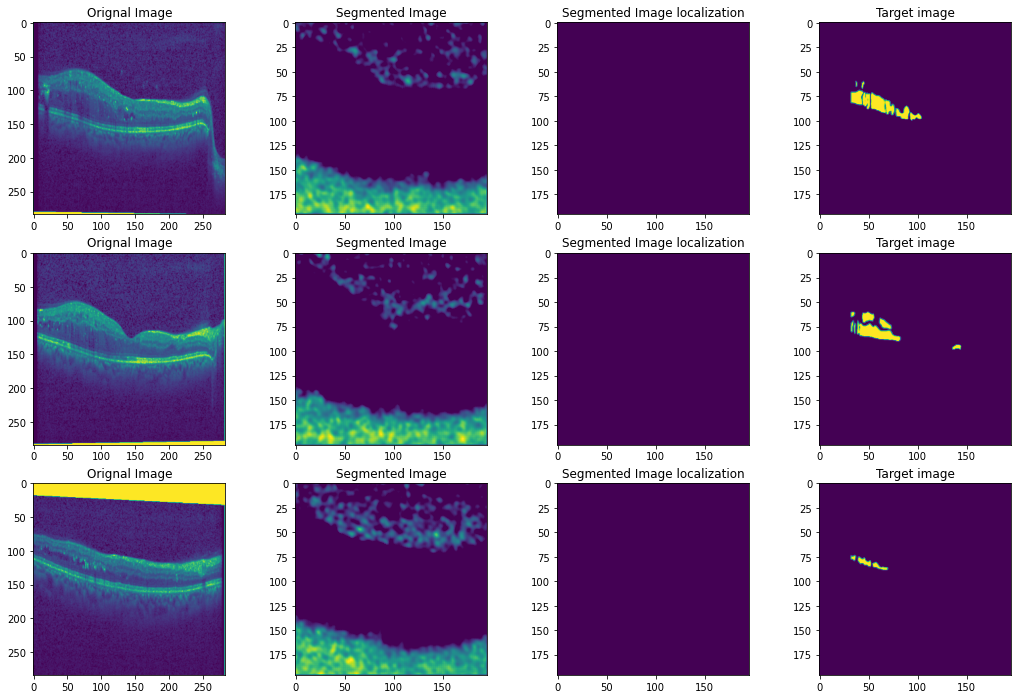

In [92]:
plot_examples(x_val, y_val)